In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.quantization
import time
import numpy as np
import matplotlib.pyplot as plt
import copy

# For reproducibility
torch.manual_seed(1910)

# Set number of epochs
NUM_EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

print("CIFAR-10 dataset loaded.")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset loaded.


In [3]:
class QuantizableModel(nn.Module):
    def __init__(self, model_fp32):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        self.model_fp32 = model_fp32
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        x = self.dequant(x)
        return x

# Create the standard floating-point model
float_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
num_features = float_model.classifier[1].in_features
float_model.classifier = nn.Linear(num_features, 10)

# Fix for residual connections to make it quantizable
for module in float_model.modules():
    if isinstance(module, torchvision.models.mobilenetv2.InvertedResidual):
        module.skip_add = nn.quantized.FloatFunctional()
        def new_forward(self, x):
            if self.use_res_connect:
                return self.skip_add.add(x, self.conv(x))
            else:
                return self.conv(x)
        module.forward = new_forward.__get__(module, type(module))

# Wrap the model for the quantization process
quantizable_model = QuantizableModel(model_fp32=float_model)
print("Quantizable model created and skip connections fixed.")

Quantizable model created and skip connections fixed.


In [4]:
# General-purpose training function
def train_model(model, trainloader, criterion, optimizer, num_epochs=10):
    print(f"\nStarting training for {num_epochs} epochs on {device}...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(trainloader):.3f}")
    print("Training complete.")
    return model

# Create a deep copy of the float model to train as a baseline
baseline_float_model = copy.deepcopy(float_model)
baseline_float_model.to(device)

# Define criterion and optimizer for the baseline model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_float_model.parameters(), lr=0.001, momentum=0.9)

# Train the baseline float model
print("--- Training Baseline Float Model ---")
trained_float_model = train_model(baseline_float_model, trainloader, criterion, optimizer, num_epochs=NUM_EPOCHS)

--- Training Baseline Float Model ---

Starting training for 10 epochs on cuda...
Epoch [1/10] Loss: 0.411
Epoch [2/10] Loss: 0.180
Epoch [3/10] Loss: 0.117
Epoch [4/10] Loss: 0.077
Epoch [5/10] Loss: 0.053
Epoch [6/10] Loss: 0.038
Epoch [7/10] Loss: 0.031
Epoch [8/10] Loss: 0.025
Epoch [9/10] Loss: 0.019
Epoch [10/10] Loss: 0.015
Training complete.


In [ ]:
quantizable_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm') # qnnpack
qat_model = torch.quantization.prepare_qat(quantizable_model.train())
print("\nModel prepared for QAT.")

c:\Users\VICTUS\anaconda3\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(



Model prepared for QAT.


In [6]:
# Re-define optimizer for the QAT model
qat_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(qat_model.parameters(), lr=0.001, momentum=0.9)

# Use the same training function for QAT
print("\n--- Training QAT Model ---")
qat_model = train_model(qat_model, trainloader, criterion, optimizer, num_epochs=NUM_EPOCHS)


--- Training QAT Model ---

Starting training for 10 epochs on cuda...
Epoch [1/10] Loss: 0.759
Epoch [2/10] Loss: 0.339
Epoch [3/10] Loss: 0.269
Epoch [4/10] Loss: 0.225
Epoch [5/10] Loss: 0.197
Epoch [6/10] Loss: 0.173
Epoch [7/10] Loss: 0.149
Epoch [8/10] Loss: 0.131
Epoch [9/10] Loss: 0.114
Epoch [10/10] Loss: 0.100
Training complete.


In [7]:
qat_model.to('cpu')
quantized_integer_model = torch.quantization.convert(qat_model.eval())
print("\nModel successfully converted to a final integer model.")


Model successfully converted to a final integer model.


c:\Users\VICTUS\anaconda3\Lib\site-packages\torch\ao\quantization\utils.py:407: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


In [8]:
# Helper function to get model size
def get_model_size_mb(model):
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p")/1e6
    os.remove("temp.p")
    return size_mb

# Helper function to evaluate accuracy and latency
def evaluate_model(model, data_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()
    if device == 'cuda':
        torch.cuda.synchronize()

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()

    total_time = end_time - start_time
    # Calculate latency per image for a more stable metric
    avg_latency_ms = (total_time / len(data_loader.dataset)) * 1000
    accuracy = 100 * correct / total
    return accuracy, avg_latency_ms

# --- Run Evaluations ---
print("\n--- Evaluating Performance ---")
# Quantized integer models must run on CPU
quant_accuracy, quant_latency = evaluate_model(quantized_integer_model, testloader, device='cpu')
quant_size = get_model_size_mb(quantized_integer_model)

# Evaluate the FAIR baseline float model on CPU for a direct latency comparison
float_accuracy, float_latency = evaluate_model(trained_float_model, testloader, device='cpu')
float_size = get_model_size_mb(trained_float_model)

print(f"\nBaseline Float Model  -> Accuracy: {float_accuracy:.2f}%, Latency: {float_latency:.4f} ms/image, Size: {float_size:.2f} MB")
print(f"Quantized Int Model   -> Accuracy: {quant_accuracy:.2f}%, Latency: {quant_latency:.4f} ms/image, Size: {quant_size:.2f} MB")


--- Evaluating Performance ---

Baseline Float Model  -> Accuracy: 95.13%, Latency: 14.0685 ms/image, Size: 9.17 MB
Quantized Int Model   -> Accuracy: 94.05%, Latency: 7.2788 ms/image, Size: 2.94 MB


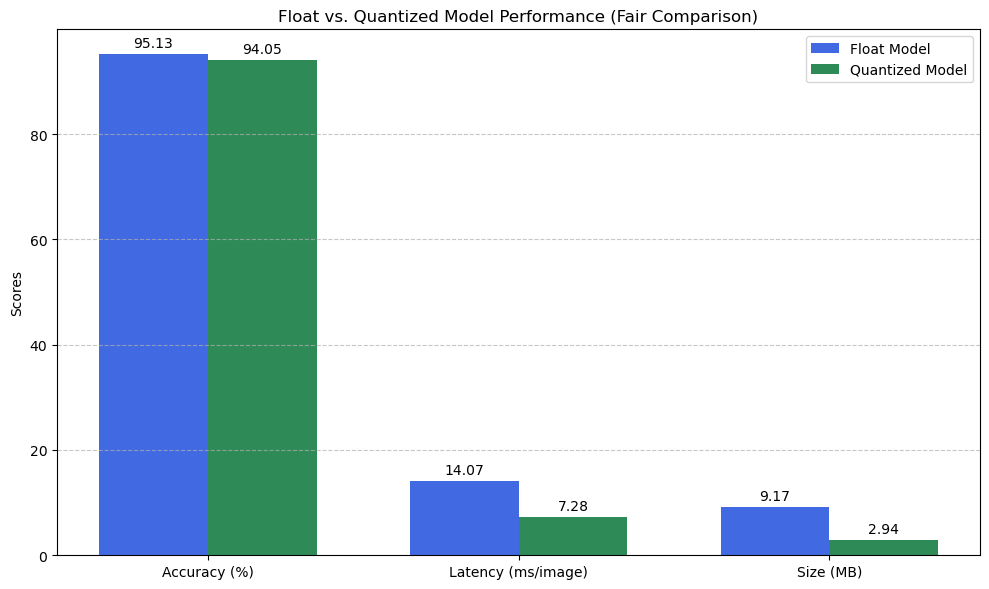

In [9]:
labels = ['Accuracy (%)', 'Latency (ms/image)', 'Size (MB)']
quant_metrics = [quant_accuracy, quant_latency, quant_size]
float_metrics = [float_accuracy, float_latency, float_size]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, float_metrics, width, label='Float Model', color='royalblue')
rects2 = ax.bar(x + width/2, quant_metrics, width, label='Quantized Model', color='seagreen')

# Add text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Float vs. Quantized Model Performance (Fair Comparison)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()